In [1]:
# install and imports
!pip install -q pandas matplotlib scipy
import os, math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

CSV_PATH = "/content/results.csv"
OUT_DIR = "/content/yolo_plots"
os.makedirs(OUT_DIR, exist_ok=True)

df = pd.read_csv(CSV_PATH)
# Strip whitespace from column names
df.columns = df.columns.str.strip()

if 'epoch' not in df.columns and 'epoch' in df:
    df.rename(columns={'epoch':'epoch'}, inplace=True)
df = df.sort_values(by=[c for c in ['epoch', 'iter'] if c in df.columns]).reset_index(drop=True)
epochs = df['epoch'] if 'epoch' in df.columns else np.arange(len(df))

def smooth(y, window=11, poly=3):
    if len(y) < window: return y
    try:
        return savgol_filter(y, window if window%2==1 else window+1, poly)
    except:
        return y

def quick_plot(xs, ys_dict, title, ylabel, save_name, smooth_win=11):
    plt.figure(figsize=(8,5))
    for label, ys in ys_dict.items():
        ys = np.array(ys)
        plt.plot(xs, ys, label=label, linewidth=1)
        if len(ys) >= 5:
            s = smooth(ys, smooth_win)
            plt.plot(xs, s, linewidth=1.5, linestyle='--')
    plt.title(title)
    plt.xlabel("epoch")
    plt.ylabel(ylabel)
    plt.grid(alpha=0.25)
    plt.legend(loc='best', fontsize='small')
    plt.tight_layout()
    path = os.path.join(OUT_DIR, save_name)
    plt.savefig(path, dpi=200)
    plt.close()
    print("Saved", path)

# Identify all training and validation loss columns to plot
all_losses_to_plot = {}
for col in df.columns:
    # Check if 'loss' is in the column name (case-insensitive)
    # and if it's either a 'train' or 'val' loss
    if 'loss' in col.lower() and ('train' in col.lower() or 'val' in col.lower()):
        all_losses_to_plot[col] = df[col].values

if all_losses_to_plot:
    quick_plot(epochs, all_losses_to_plot, "Training and Validation Losses", "Loss Value", "training_validation_losses.png", smooth_win=9)
else:
    print("No training or validation loss columns found.")


metric_cols_candidates = {
    "mAP50-95": ["metrics/mAP50-95(B)","metrics/mAP_0.5:0.95","map50_95","mAP_0.5:0.95","mAP50-95","mAP_50_95"],
    "mAP50": ["metrics/mAP50(B)","metrics/mAP_0.5","map50","mAP_0.5","mAP50"],
    "precision": ["metrics/precision(B)","metrics/precision","precision","pr"],
    "recall": ["metrics/recall(B)","metrics/recall","recall","re"]
}
found_metrics = {}
for k, poss in metric_cols_candidates.items():
    for p in poss:
        if p in df.columns:
            found_metrics[k] = df[p].values
            break

if found_metrics:
    quick_plot(epochs, found_metrics, "Validation metrics", "score", "metrics.png", smooth_win=7)
else:
    print("No standard metric columns found. Available columns:", list(df.columns))

lr_cols = [c for c in df.columns if 'lr' in c.lower() or 'learning_rate' in c.lower()]
if lr_cols:
    lr_dict = {c: df[c].values for c in lr_cols}
    quick_plot(epochs, lr_dict, "Learning rate", "lr", "lr.png", smooth_win=7)

other_cols = {}
for c in ['targets','img_size','images','box_count','n_targets']:
    if c in df.columns:
        other_cols[c] = df[c].values
if other_cols:
    for c, vals in other_cols.items():
        quick_plot(epochs, {c: vals}, c, c, f"{c}.png", smooth_win=5)

# If there are per-epoch per-class mAP or loss columns like 'map_0.5_c1' list them
perclass = {c: df[c].values for c in df.columns if any(x in c.lower() for x in ['_c','class','/']) and c not in all_losses_to_plot.keys()}
if perclass:
    sample = dict(list(perclass.items())[:6])
    quick_plot(epochs, sample, "Per-class (sample)", "value", "per_class_sample.png", smooth_win=7)

print("Columns in the CSV:", list(df.columns))
print("Plots written to", OUT_DIR)

Saved /content/yolo_plots/training_validation_losses.png
Saved /content/yolo_plots/metrics.png
Saved /content/yolo_plots/lr.png
Saved /content/yolo_plots/per_class_sample.png
Columns in the CSV: ['epoch', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']
Plots written to /content/yolo_plots


Detected columns: {'train_box': 'train/box_loss', 'train_cls': 'train/cls_loss', 'train_dfl': 'train/dfl_loss', 'val_box': 'val/box_loss', 'val_cls': 'val/cls_loss', 'val_dfl': 'val/dfl_loss', 'prec': 'metrics/precision(B)', 'recall': 'metrics/recall(B)', 'map50': 'metrics/mAP50(B)', 'map50_95': 'metrics/mAP50-95(B)'}


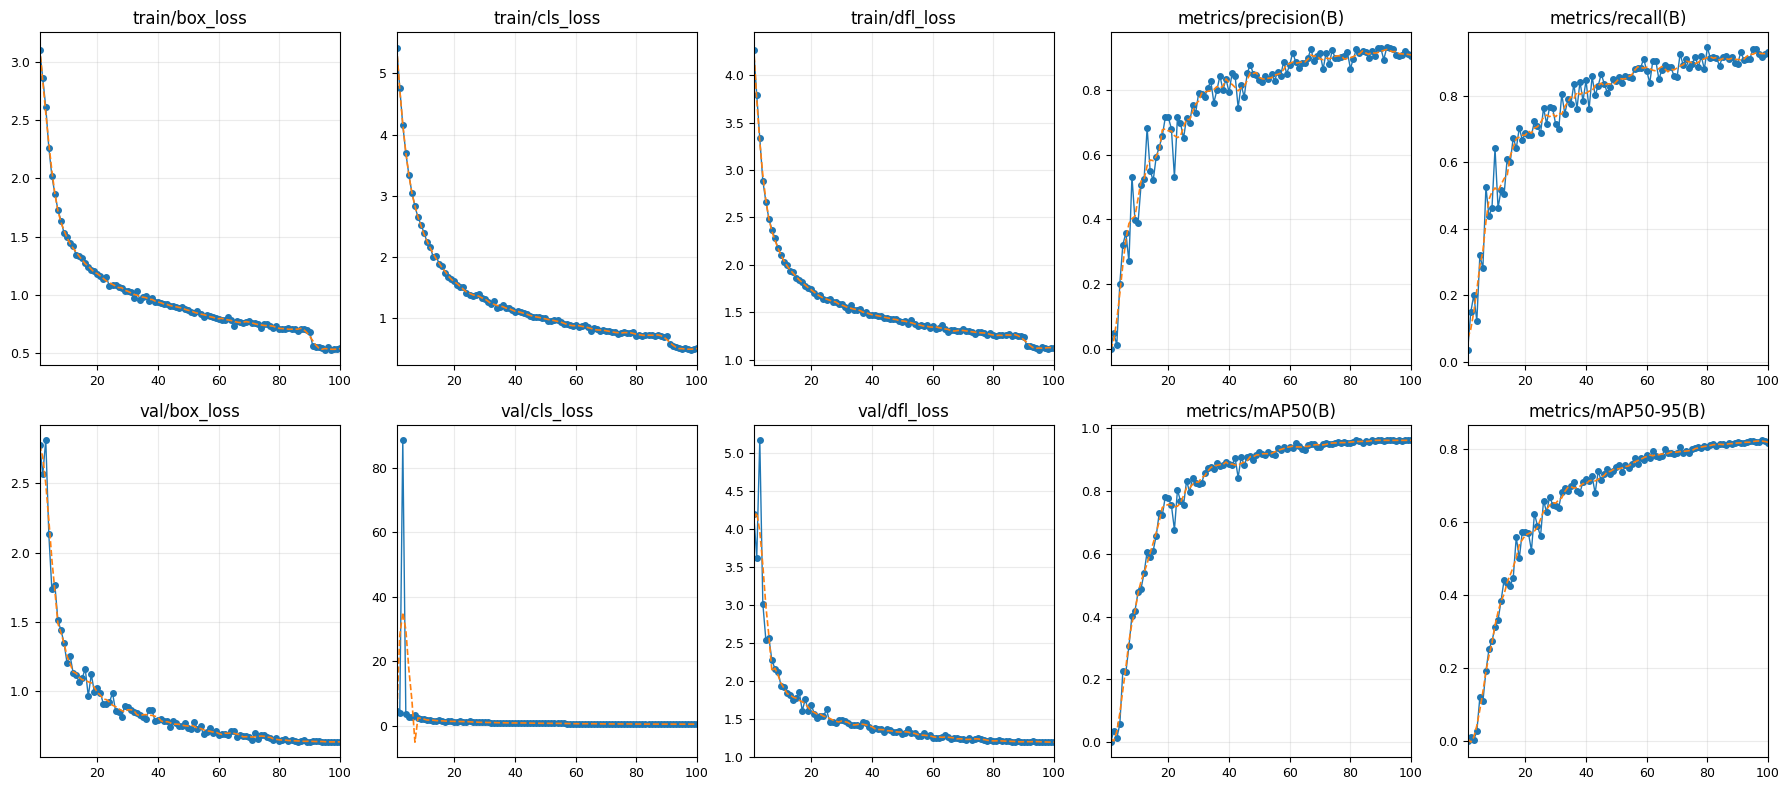

Saved combined: /content/yolo_plots/results.png
Saved /content/yolo_plots/P_curve.png
Saved /content/yolo_plots/R_curve.png
Saved /content/yolo_plots/F1_curve.png
Saved /content/yolo_plots/PR_curve.png
All plots -> /content/yolo_plots


In [3]:
# single-cell Colab: recreate YOLOv8 "base" plots + separate P/R/F1/PR and results.png
!pip install -q pandas matplotlib scipy
import os, re, math, pandas as pd, numpy as np, matplotlib.pyplot as plt
from scipy.signal import savgol_filter
CSV_PATH = "/content/results.csv"   # << set your uploaded path
OUT_DIR = "/content/yolo_plots"
os.makedirs(OUT_DIR, exist_ok=True)

# --- load & prep ---
df = pd.read_csv(CSV_PATH)
df.columns = df.columns.str.strip()
df = df.sort_values(by=[c for c in ['epoch','iter'] if c in df.columns]).reset_index(drop=True)
epochs = df['epoch'] if 'epoch' in df.columns else np.arange(len(df))

def find_col(poss):
    cols = {c.lower():c for c in df.columns}
    for p in poss:
        if p in df.columns: return p
        if p.lower() in cols: return cols[p.lower()]
    return None

def smooth(y, win=9, poly=3):
    y=np.asarray(y,dtype=float)
    if len(y)<=win: return y
    try: return savgol_filter(y, win if win%2==1 else win+1, poly)
    except: return y

def plot_line(ax,x,y,label=None,show_smooth=True,win=9):
    ax.plot(x,y,marker='o',linewidth=1,markersize=4,label='results' if label is None else label)
    if show_smooth and len(y)>=5:
        s=smooth(y,win); ax.plot(x,s,linestyle='--',linewidth=1.2,label='smooth')
    ax.grid(alpha=0.25); ax.set_xlim(x.min(), x.max())

# --- target columns (flexible names) ---
cols = {
 'train_box': ['train/box_loss','train/box','box_loss','box'],
 'train_cls': ['train/cls_loss','train/cls','cls_loss','cls'],
 'train_dfl': ['train/dfl_loss','train/dfl','dfl_loss','dfl'],
 'val_box'  : ['val/box_loss','val/box','val_box','val/box_loss','val_box_loss'],
 'val_cls'  : ['val/cls_loss','val/cls','val_cls','val/cls_loss','val_cls_loss'],
 'val_dfl'  : ['val/dfl_loss','val/dfl','val_dfl','val/dfl_loss','val_dfl_loss'],
 'prec'     : ['metrics/precision(B)','metrics/precision','precision','pr'],
 'recall'   : ['metrics/recall(B)','metrics/recall','recall','re'],
 'map50'    : ['metrics/mAP50(B)','metrics/mAP_0.5','map50','mAP_0.5','map_0.5'],
 'map50_95' : ['metrics/mAP50-95(B)','metrics/mAP_0.5:0.95','map50_95','mAP_0.5:0.95','mAP50-95']
}
found = {k: find_col(v) for k,v in cols.items()}
print("Detected columns:", found)

# --- build numeric series (or NaNs) ---
series = {}
for k,c in found.items():
    series[k] = df[c].astype(float).to_numpy() if c is not None else np.full(len(epochs), np.nan)

# compute F1 if possible
P, R = series['prec'], series['recall']
with np.errstate(divide='ignore', invalid='ignore'):
    F1 = np.where((P+R)>0, 2*P*R/(P+R), np.nan)
series['f1']=F1

# --- 2x5 grid exactly as image: top: train box/cls/dfl, precision, recall
fig, axes = plt.subplots(2,5, figsize=(18,8))
axes = axes.flatten()
plot_pairs = [
 ('train_box','train_cls','train_dfl','prec','recall'),
 ('val_box','val_cls','val_dfl','map50','map50_95')
]
# fill first row
for i,k in enumerate(plot_pairs[0]):
    ax = axes[i]
    y = series[k]
    if np.isnan(y).all(): ax.text(0.5,0.5,"missing",ha='center'); ax.set_title(k)
    else:
        plot_line(ax, np.array(epochs), y); ax.set_title( (found[k] or k) )
# second row
for i,k in enumerate(plot_pairs[1]):
    ax = axes[5+i]
    y = series[k]
    if np.isnan(y).all(): ax.text(0.5,0.5,"missing",ha='center'); ax.set_title(k)
    else:
        plot_line(ax, np.array(epochs), y); ax.set_title( (found[k] or k) )
# tidy
for ax in axes: ax.tick_params(labelsize=9)
plt.tight_layout()
results_path = os.path.join(OUT_DIR,"results.png")
plt.savefig(results_path, dpi=200); plt.show()
print("Saved combined:", results_path)

# --- save separate curves: P, R, F1, PR (precision vs recall) ---
def save_single(name, x, y, ylabel):
    fig, ax = plt.subplots(figsize=(5,4))
    plot_line(ax, x, y)
    ax.set_title(name); ax.set_ylabel(ylabel); ax.set_xlabel("epoch")
    pth = os.path.join(OUT_DIR, name.replace(" ","_")+".png")
    plt.tight_layout(); plt.savefig(pth, dpi=200); plt.close(); print("Saved", pth)

if not np.isnan(P).all(): save_single("P_curve", np.array(epochs), P, "precision")
if not np.isnan(R).all(): save_single("R_curve", np.array(epochs), R, "recall")
if not np.isnan(F1).all(): save_single("F1_curve", np.array(epochs), F1, "f1")
# PR curve: precision vs recall (points colored by epoch)
if (not np.isnan(P).all()) and (not np.isnan(R).all()):
    fig, ax = plt.subplots(figsize=(5,5))
    ax.plot(R, P, marker='o', linewidth=1)
    ax.set_xlabel("recall"); ax.set_ylabel("precision"); ax.set_title("PR_curve")
    pth=os.path.join(OUT_DIR,"PR_curve.png"); plt.tight_layout(); plt.savefig(pth,dpi=200); plt.close(); print("Saved", pth)

print("All plots ->", OUT_DIR)

In [4]:
import shutil

# Define the directory to zip and the output zip file name
folder_to_zip = '/content/yolo_plots'
output_zip_file = '/content/yolo_plots'

# Create a zip archive of the folder
shutil.make_archive(output_zip_file, 'zip', folder_to_zip)

print(f"Folder '{folder_to_zip}' successfully zipped to '{output_zip_file}.zip'")
print("You can now download this file from the Colab file browser (the folder icon on the left sidebar).")

Folder '/content/yolo_plots' successfully zipped to '/content/yolo_plots.zip'
You can now download this file from the Colab file browser (the folder icon on the left sidebar).
